# Introduction to StrAss-PINN

## Software prerequisite

In [1]:
try:
    from SineLayer import Siren
    from Dynamics import *
    from netCDF4 import Dataset as d
    import torch
    from torch.utils.data import DataLoader, Dataset
    from PIL import Image
    from torchvision.transforms import Resize, Compose, ToTensor, Normalize
    import numpy as np
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    import matplotlib.animation as anim
    
    print("All packages are installed!")
except ImportError as e:
    print(f"An error occurred: {e}. Please make sure all required packages are installed.")

All packages are installed!


In [2]:
def grab(var):
    return var.detach().cpu().numpy()

## Load the dataset

In [3]:
# Read params.in
with open('Dataset_oceano/params.in', 'r') as f:
    params_data = f.readlines()
    
for line in params_data[1:]:
    print(line)

# Read vars.nc
nc_file = 'Dataset_oceano/vars.nc'
nc_dataset = d(nc_file, 'r')

# Save the variables of interest
variable_data = nc_dataset.variables['psi'][:]
x = nc_dataset.variables['x'][:]
y = nc_dataset.variables['y'][:]

nc_dataset.close()

# input parameter file

# double gyre 

NX  = 512

NY  = 512

nl = 3

Lx = 4000e3

f0 = 9.4e-05

beta = 1.7e-11

tau0 = 1.3e-5

forc_mode = 2.0



# bc_fac = 0: free slip, 1: no slip, [0..1]: partial slip

bc_fac = 0.

# dh must be an array

dh = [350., 750., 2900.]

N2 = [4.54545455e-05, 6.84931507e-06]



nu = 40

hEkb = 2



# timestepping

#tend  = 6307200000 # 200 years

#dt_out = 2592000 # 30 days

dt_out = 86400 # 1 days

tend  = 31536000 # 1 year



In [4]:
def get_flow_tensor(sidelen, timelen, level):
    img = Image.fromarray(variable_data[0:10*timelen:10][:, level].reshape(513*timelen, 513))
    transform = Compose([
        Resize((timelen*sidelen, sidelen)),
        ToTensor()
    ])
    img = transform(img)
    img = img.reshape(timelen, sidelen, sidelen)
    return img

def get_grid(sidelen, timelen):
    """
        Définit la grille (x, y, t)
    """
    x = torch.linspace(-1, 1, steps=sidelen)
    y = torch.linspace(-1, 1, steps=sidelen)
    t = torch.linspace(-1, 1, steps=timelen)
    mgrid = torch.stack(torch.meshgrid(t, x, y), dim=-1)
    mgrid = mgrid.reshape(-1, 3)
    mgrid = torch.stack((mgrid[:, 0], mgrid[:, 2], mgrid[:, 1]), dim=-1)
    return mgrid

def get_data():
    data_psi1 = torch.load('Dataset_oceano_masked/psi1_128_100j')

    mask = torch.load('Dataset_oceano_masked/mask_128_100j')
    coords = torch.load('Dataset_oceano_masked/coords_128_100j')
    std = torch.load('Dataset_oceano_masked/std_128_100j')
    return data_psi1, coords, mask, std

In [5]:
class SWOT(Dataset):
    def __init__(self):
        super().__init__()
        self.shape = (t_size, img_size, img_size)
        self.psi, self.coords, self.mask, self.std = get_data()

    def __len__(self):
        return len(self.psi)

    def __getitem__(self, idx):
        if idx > self.__len__(): raise IndexError
        return self.coords[idx], self.psi[idx]

    def show(self):
        obs = np.zeros(10*np.prod(self.shape))
        obs[self.mask] = self.psi
        V = np.quantile(obs, 0.99)
        plt.imshow(obs.reshape(-1, img_size, img_size)[0], cmap='seismic', origin='lower', vmin=-V, vmax=V)
        plt.xlabel('$x$', fontsize=40)
        plt.ylabel('$y$', fontsize=40, rotation="horizontal", labelpad=25)
        plt.xticks([])
        plt.yticks([])

class ARGO(Dataset):
    def __init__(self, level, idx=None):
        nb_points = nb_buoys*t_size if level==1 else nb_buoys*t_size//10
        
        if idx is None:
            self.idx = torch.randperm(t_size*img_size*img_size)[:nb_points]
        else:
            self.idx = idx
        super().__init__()
        psi = get_flow_tensor(128, 10, level)
        psi = psi.view(-1, 1)[self.idx]
        mean, self.std = psi.mean(), psi.std()
        self.psi = (psi - mean)/self.std
        self.coords = get_grid(img_size, t_size)[self.idx, :]

    def __len__(self):
        return len(self.psi)

    def __getitem__(self, idx):
        if idx > self.__len__(): raise IndexError
        return self.coords[idx], self.psi[idx]

class Regularizer(Dataset):
    def __init__(self, nb_reg, level):
        super().__init__()
        self.coords = torch.zeros(nb_reg, 3).uniform_(-1, 1)
        self.gradpsi_below = torch.zeros(nb_reg, 3).view(-1, 3)
        self.gradpsi_above = torch.zeros(nb_reg, 3).view(-1, 3)
        self.level = level
        self.lappsi_above = torch.zeros(nb_reg)
        self.lappsi_below = torch.zeros(nb_reg)
        if self.level==0:
            self.forc = wind_forc(self.coords)

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        if idx > self.__len__(): raise IndexError

        if self.level==0:
            return self.coords[idx], self.gradpsi_below[idx], self.lappsi_below[idx], self.forc[idx]
        elif self.level==1:
            return self.coords[idx], self.gradpsi_above[idx], self.lappsi_above[idx], self.gradpsi_below[idx], self.lappsi_below[idx]
        else:
            return self.coords[idx], self.gradpsi_above[idx], self.lappsi_above[idx]

## Define the networks

In [6]:
wt = 1.5
kx = 10

psi1 = Siren(in_features=3, out_features=1, hidden_features=64, hidden_layers=2, outermost_linear=True,
             first_omega_0=3*kx, omega_0_t=3*wt)
psi2 = Siren(in_features=3, out_features=1, hidden_features=64, hidden_layers=2, outermost_linear=True,
             first_omega_0=3*kx, omega_0_t=3*wt)
psi3 = Siren(in_features=3, out_features=1, hidden_features=64, hidden_layers=2, outermost_linear=True,
             first_omega_0=3*kx, omega_0_t=3*wt)

/opt/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Define the training dataset for $\tilde{\Psi}_1$

In [7]:
img_size = 128
t_size = 10

nb_surface = 203901 # Number of observation points at the surface
nb_buoys = 800

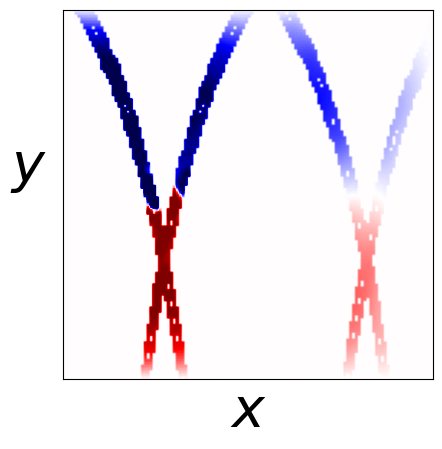

In [8]:
batch_size_surf = nb_surface//100
batch_size_reg = 2048

swot = SWOT()
reg_psi1 = Regularizer(10*batch_size_reg, 0)
obs1 = DataLoader(swot, batch_size=batch_size_surf, pin_memory=False, num_workers=0, shuffle=True)
reg1 = DataLoader(reg_psi1, batch_size=batch_size_reg, pin_memory=False, num_workers=0, shuffle=True)

swot.show()

In [9]:
nb_epochs = 200

optim = torch.optim.Adam(lr=1e-3, params=psi1.parameters())

pbar = tqdm(range(nb_epochs))

loglossdata_1 = []
loglossdyn_1 = []

lam = 0.0001

for epoch in pbar:
    for step, [[input_data, gt_psi1], [input_reg, _, _, forc]] in enumerate(zip(obs1, reg1)):
        output_data, _ = psi1(input_data)
        loss_data = ((output_data[:, 0].clone() - gt_psi1) ** 2).mean()
        
        output_reg, coords = psi1(input_reg)
        loss_dyn = lam*((dyn_psi1_0(swot.std*output_reg, coords, forc) ** 2).mean())

        loss = loss_data + loss_dyn

        optim.zero_grad()
        loss.backward()
        optim.step()

        loglossdata_1.append(loss_data.cpu().detach().numpy())
        loglossdyn_1.append(loss_dyn.cpu().detach().numpy())

        pbar.set_description("Total loss : %0.6f. Progress " % loss)

print("Psi_1 DONE")

Total loss : 0.003201. Progress : 100%|███████| 200/200 [34:51<00:00, 10.46s/it]

Psi_1 DONE


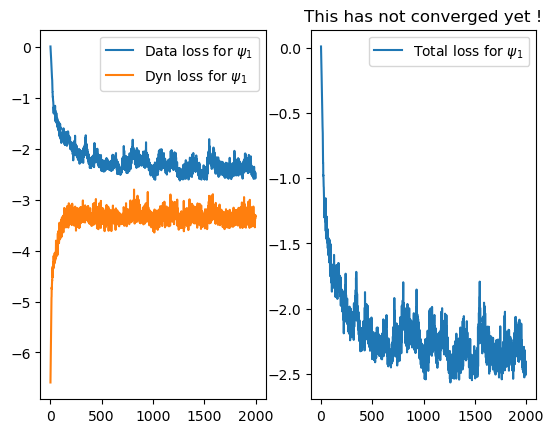

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

loglossdata_1, loglossdyn_1 = np.array(loglossdata_1), np.array(loglossdyn_1)

ax1.plot(np.log10(np.abs(loglossdata_1)), label="Data loss for $\psi_1$")
ax1.plot(np.log10(np.abs(loglossdyn_1)), label="Dyn loss for $\psi_1$")
ax1.legend()

ax2.plot(np.log10(np.abs(loglossdata_1+loglossdyn_1)), label="Total loss for $\psi_1$")
ax2.legend()
ax2.set_title("This has not converged yet !");

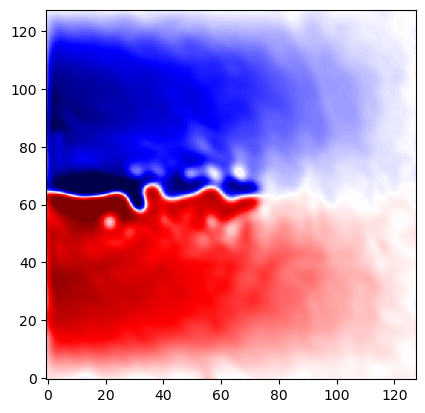

In [11]:
coords = get_grid(128, 10)
res_1 = grab(psi1(coords)[0])
v = np.quantile(res_1, 0.99)

plt.imshow(res_1.reshape(10, 128, 128)[0], cmap="seismic", vmin=-v, vmax=v, origin="lower")

## Repeat for $\tilde{\Psi}_2$ and $\tilde{\Psi}_3$ propagating information downward

In [12]:
batch_size_int = nb_buoys
batch_size_reg = 2048 # One may want to change batch_size_reg, nb_epochs and lam but we won't do this here

argo_int = ARGO(1)
reg_psi2 = Regularizer(10*batch_size_reg, 1)

coords = reg_psi2.coords
out1, coords = psi1(coords)
gradpsi1 = gradient(swot.std*out1, coords)
lappsi1 = divergence(gradpsi1, coords).detach() # The graph to compute ΔΨ_1 is not useful to train Ψ_2...

reg_psi2.gradpsi_above = gradpsi1.detach() # ...and neither is the one for ∇Ψ_1
reg_psi2.lappsi_above = lappsi1

obs2 = DataLoader(argo_int, batch_size=batch_size_int, pin_memory=False, num_workers=0, shuffle=True)
reg2 = DataLoader(reg_psi2, batch_size=batch_size_reg, pin_memory=False, num_workers=0, shuffle=True)

idx2 = argo_int.idx # Save where the buoys are for later

In [13]:
nb_epochs = 200

optim = torch.optim.Adam(lr=5e-4, params=psi2.parameters())

pbar = tqdm(range(nb_epochs))

loglossdata_2 = []
loglossdyn_2 = []

best = 1000

for epoch in pbar:
    for step, [[input_data, gt_psi2], [input_reg, gradpsi1, lappsi1, _, _]] in enumerate(zip(obs2, reg2)):
        output_data, _ = psi2(input_data)

        output_reg, coords = psi2(input_reg)

        loss_data = ((output_data - gt_psi2) ** 2).mean()
        loss_dyn = lam*((dyn_psi2_0(argo_int.std*output_reg, coords, gradpsi1, lappsi1) ** 2).mean())
        loss = loss_data + loss_dyn

        optim.zero_grad()
        loss.backward()
        optim.step()

        loglossdata_2.append(loss_data.cpu().detach().numpy())
        loglossdyn_2.append(loss_dyn.cpu().detach().numpy())

        pbar.set_description("Total loss %0.6f. Progress " % loss)

print("Psi_2 DONE")

Total loss 0.010871. Progress : 100%|█████████| 200/200 [31:39<00:00,  9.50s/it]

Psi_2 DONE


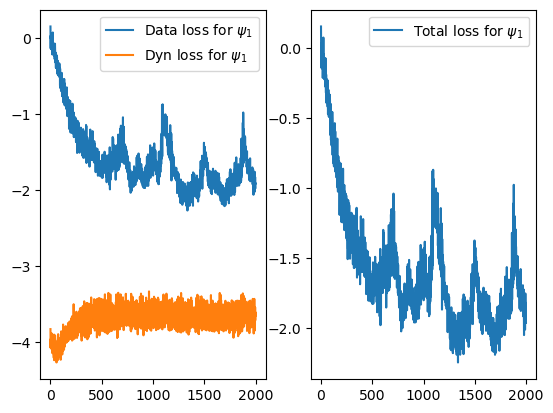

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

loglossdata_2, loglossdyn_2 = np.array(loglossdata_2), np.array(loglossdyn_2)

ax1.plot(np.log10(np.abs(loglossdata_2)), label="Data loss for $\psi_1$")
ax1.plot(np.log10(np.abs(loglossdyn_2)), label="Dyn loss for $\psi_1$")
ax1.legend()

ax2.plot(np.log10(np.abs(loglossdata_2+loglossdyn_2)), label="Total loss for $\psi_1$")
ax2.legend()

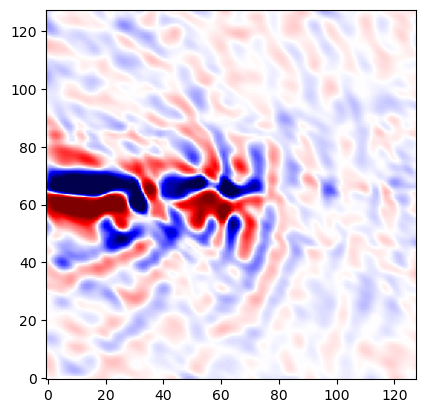

In [15]:
coords = get_grid(128, 10)
res_2 = grab(psi2(coords)[0])
v = np.quantile(res_2, 0.99)

plt.imshow(res_2.reshape(10, 128, 128)[0], cmap="seismic", vmin=-v, vmax=v, origin="lower")

In [16]:
batch_size_bot = nb_buoys//10
batch_size_reg = 2048

argo_bot = ARGO(2)
reg_psi3 = Regularizer(10*batch_size_reg, 2)

coords = reg_psi3.coords
out2, coords = psi2(coords)
gradpsi2 = gradient(argo_int.std*out2, coords)
lappsi2 = divergence(gradpsi2, coords).detach() # Again, discard the graph to compute ΔΨ_2...

reg_psi3.gradpsi_above = gradpsi2.detach() # ... and the graph for ∇Ψ_2
reg_psi3.lappsi_above = lappsi2

obs3 = DataLoader(argo_bot, batch_size=batch_size_bot, pin_memory=False, num_workers=0, shuffle=True)
reg3 = DataLoader(reg_psi3, batch_size=batch_size_reg, pin_memory=False, num_workers=0, shuffle=True)

idx3 = argo_bot.idx

In [17]:
nb_epochs = 200

optim = torch.optim.Adam(lr=1e-4, params=psi3.parameters())

pbar = tqdm(range(nb_epochs))

loglossdata_3 = []
loglossdyn_3 = []

best = 1000

for epoch in pbar:
    for step, [[input_data, gt_psi3], [input_reg, gradpsi2, lappsi2]] in enumerate(zip(obs3, reg3)):
        output_data, _ = psi3(input_data)

        output_reg, coords = psi3(input_reg)

        loss_data = ((output_data - gt_psi3) ** 2).mean()
        loss_dyn = lam*((dyn_psi3(argo_bot.std*output_reg, coords, gradpsi2, lappsi2) ** 2).mean())
        loss = loss_data + loss_dyn

        optim.zero_grad()
        loss.backward()
        optim.step()

        loglossdata_3.append(loss_data.cpu().detach().numpy())
        loglossdyn_3.append(loss_dyn.cpu().detach().numpy())

        pbar.set_description("Total loss %0.6f. Progress " % loss)
        
print("Psi_3 DONE")

Total loss 0.011099. Progress : 100%|█████████| 200/200 [26:40<00:00,  8.00s/it]

Psi_3 DONE


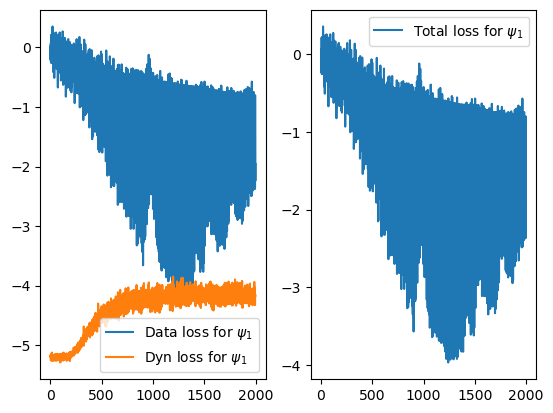

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

loglossdata_3, loglossdyn_3 = np.array(loglossdata_3), np.array(loglossdyn_3)

ax1.plot(np.log10(np.abs(loglossdata_3)), label="Data loss for $\psi_1$")
ax1.plot(np.log10(np.abs(loglossdyn_3)), label="Dyn loss for $\psi_1$")
ax1.legend()

ax2.plot(np.log10(np.abs(loglossdata_3+loglossdyn_3)), label="Total loss for $\psi_1$")
ax2.legend()

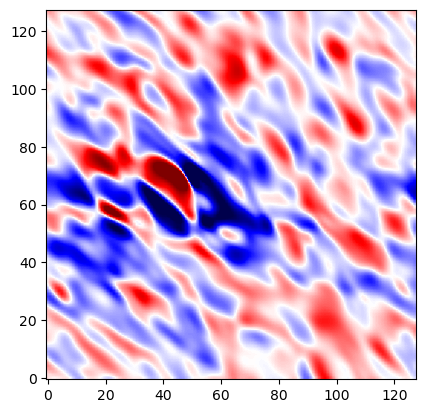

In [19]:
coords = get_grid(128, 10)
res_3 = grab(psi3(coords)[0])
v = np.quantile(res_3, 0.99)

plt.imshow(res_3.reshape(10, 128, 128)[0], cmap="seismic", vmin=-v, vmax=v, origin="lower")